# TUTORIAL 
# Real thermoacoustic data from an annular combustor




In [12]:
from aux_tutorials import *
from essentials.models_physical import Annular
from essentials.Util import *

data_folder, results_folder, figs_folder = set_working_directories('annular/')



The data available in data_folder are acoustic pressure measurements at the azimuthal locations $ \theta = 0^\circ, 60^\circ, 120^\circ, 240^\circ.$
 
Each .mat data file represents an experiment at different equivalence ratios $\Phi = 0.4875, ..., 0.5750$ (by steps of $0.0125$); and the file includes the variables
- y_raw: raw acoustic pressure recordings 
- y_filtered: post-processed acoustic pressure (mean offset correction and bandpass filter)
- t: timestamp of the recordings


In [19]:
# Define .mat file names and equivalence ratios
ERs = 0.4875 + np.arange(0, 4) * 0.025
files = [data_folder + 'ER_{}.mat'.format(ER) for ER in ERs]



Using the functions "nu_from_ER" and "c2beta_from_ER" we can compute fore each equivalence ratio the linear growth rate $\nu$ and the asymmetry parameter group $c_2\beta$, which allows us to replicate Fig. 9 in [Indlekofer et al. (2022)](https://doi.org/10.1017/jfm.2022.468).



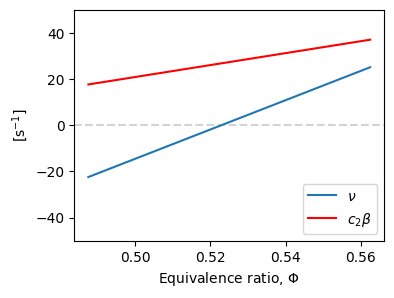

In [20]:
NUs, C2Bs = [], []
for ER in ERs:
    NUs.append(Annular.nu_from_ER(ER))
    C2Bs.append(Annular.c2beta_from_ER(ER))

fig = plt.figure(figsize=(4, 3))
plt.axhline(y=0, color='lightgrey', ls='--')
plt.plot(ERs, NUs, '-', color='C0', label='$\\nu$')
plt.plot(ERs, C2Bs, '-', color='r', label=Annular.alpha_labels['c2beta'])
plt.xlabel('Equivalence ratio, $\Phi$')
plt.ylabel('[s$^{-1}$]')
plt.ylim([-50, 50])
plt.legend(loc='lower right');



Let's visualize the power spectral density (PSD) of the acoustic pressure for each equivalence ratio.

In the resulting figure we can see that some of the experiments had the microphone at $\theta=120^\circ$ off, as the PSD is zero.


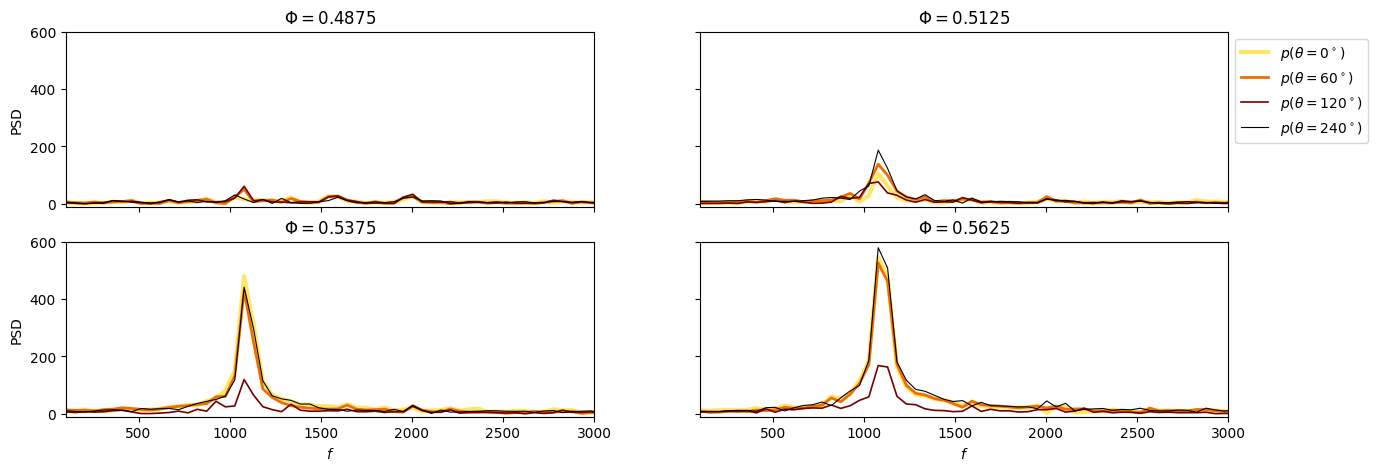

In [21]:
import scipy.io as sio

def fun_PSD(X):
    if X.shape[0] > X.shape[1]:
        X = X.T
    PSD = []
    for x in X:
        yt = np.fft.fft(x)
        PSD.append(2.0 / X.shape[-1] * np.abs(yt[0:X.shape[-1] // 2]))
    return PSD

N, upsample = 1000, 2

fig1 = plt.figure(figsize=(15, 5))
axs = fig1.subplots(2, len(ERs)//2, sharey='all', sharex='all')
for ER, name, ax in zip(ERs, files, axs.ravel()):
    mat = sio.loadmat(name)
    y_raw, t_obs = [mat[key] for key in ['y_raw', 't']]
    y_raw = y_raw[-N::upsample]
    if ER == ERs[0]:
        Nq = y_raw.shape[-1]
        t_obs = t_obs.squeeze()[::upsample]
        dt = t_obs[1]-t_obs[0]
        f = np.linspace(0.0, 1.0 / (2.0 * dt), (N//upsample) // 2)
        colors = plt.cm.afmhot(np.linspace(0,0.7,Nq))[::-1]
        
    psd = fun_PSD(X=y_raw)
    for psd_, c, lw in zip(psd, colors, [3, 2, 1.2, 0.8]):
        ax.plot(f, psd_, color=c, lw=lw)
    ax.set(title='$\Phi={}$'.format(ER))
    
leg = ['$p(\\theta={}^\circ)$'.format(deg) for deg in [0, 60, 120, 240]]
axs[0, -1].legend(leg, loc='upper left', bbox_to_anchor=(1, 1))
[ax.set(xlabel='$f$') for ax in axs[1, :]]
[ax.set(ylabel='PSD', xlim=[100, 3000], ylim=[-10, 600]) for ax in axs[:, 0]];


We focus now on a single experiment. We can visualize the instantaneous pressure at each microphone. 
The figure shows how 
1. the post-processed data (i.e., y_filtered) is zero-mean, 
2. the post-processed signals are smoother, and
3. the raw pdfs are wider and more flat.

In [24]:
# Select an equivalence ratio
idx = -1
ER, name = ERs[idx], files[idx]

# Load data
mat = sio.loadmat(name)
y_raw, y_filter, t = [mat[key] for key in ['y_raw', 'y_filtered', 't']]
t = t.squeeze()
Nq = y_raw.shape[-1]


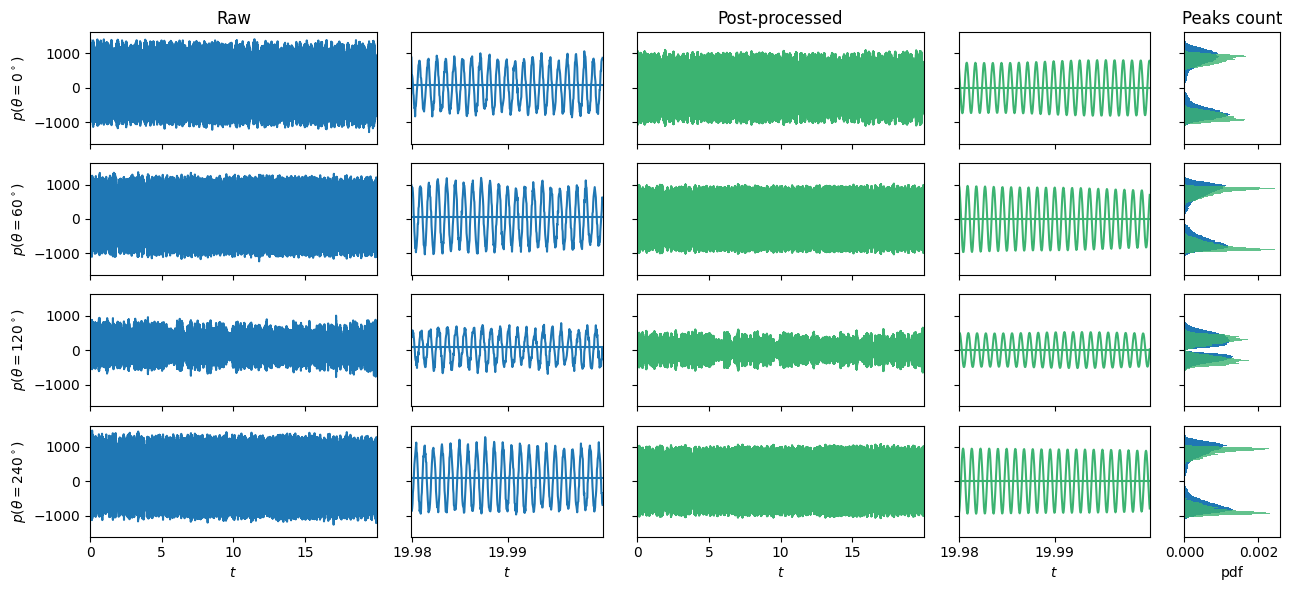

In [27]:

from scipy.signal import find_peaks

upsample = 2
N_max = int(20 / (t[1] - t[0])) 

y_raw_, y_filter_, t_ = [xx[0:N_max:upsample] for xx in [y_raw, y_filter, t]]


fig1 = plt.figure(figsize=(13, 1.5 * Nq), layout="tight")
titles = ['Raw', 'Post-processed']
labels_y = ['$p(\\theta={}^\circ)$'.format(th) for th in [0, 60, 120, 240]]
cols = ['tab:blue', 'mediumseagreen']

max_y, N_zoom = np.max(y_raw_), int(0.0201 // (t_[1] - t_[0]))
# Plot zoomed timeseries of raw, post-processed and noise
axs = fig1.subplots(Nq, 5, sharex='col', sharey='all', width_ratios=[1.5, 1, 1.5, 1, 0.5])
ax_raw , ax_filter, ax_pdf= axs[:, :2], axs[:, 2:4], axs[:, -1]

for ax, yy, ttl, c in zip([ax_raw, ax_filter], [y_raw_, y_filter_], titles, cols):
    ax[0, 0].set(title=ttl)
    ax[-1, 0].set(xlabel='$t$', xlim=[t_[0], t_[-1]])
    ax[-1, -1].set(xlabel='$t$', xlim=[t_[-N_zoom], t_[-1]])
    for qi in range(Nq):
        ax[qi, 0].plot(t_[:-N_zoom], yy[:-N_zoom, qi], color=c)
        ax[qi, 1].plot(t_[-N_zoom:], yy[-N_zoom:, qi], color=c)
        ax[qi, 1].axhline(np.mean(yy[:, qi]), color=c) 
        if ttl == titles[0]:
            ax[qi, 0].set(ylabel=labels_y[qi])

bins = np.arange(-max_y, max_y + 0.01 * max_y, 0.01 * max_y)
for yy, ttl, c, a in zip([y_raw_, y_filter_], titles, cols, [1, 0.8]):
    ax_pdf[0].set(title='Peaks count')
    ax_pdf[-1].set(xlabel='pdf')
    for qi in range(Nq):
        peaks = find_peaks(abs(yy[:, qi]))[0]
        ax_pdf[qi].hist(yy[peaks, qi], bins=bins, density=True, orientation='horizontal', color=c, alpha=a)
